

| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_df  | 캠벨얼리 가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 샤인머스켓 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급    |20190101 ~ 20201104|
| shinemuscat_df   |샤인마스캇  가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 블루베리 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급        |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|


**train accuracy / test accuracy 의 차이 비교 overfitting = 20% 이상 (10~20%)**

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

/var/folders/lm/z4n_2b8s6rj3_vv57sg789kc0000gn/T/ipykernel_29168/2031877544.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# iMACA
raw_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/processed/'

In [2]:
# Macbook
# raw_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/raw/'
# processed_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/processed/'

In [8]:
# tomato = pd.read_csv(processed_path+'tomato.csv')
grape = pd.read_csv(processed_path+'캠벨얼리_전처리후.csv')
shinemuscat = pd.read_csv(processed_path+'샤인머스켓_전처리후.csv')

train = pd.read_csv(raw_path+'train.csv')
test = pd.read_csv(raw_path+'test.csv')
private = pd.read_csv(raw_path+'private_data.csv')
submission = pd.read_csv(raw_path+'sample_submission.csv')

print(grape.shape)
print(shinemuscat.shape)
print(private.shape)
print(submission.shape)

(1770, 9)
(1770, 9)
(291, 44)
(228, 22)


# LGBM(LightGBM)

## 캠벨얼리
성능을 알아보기 위한 모델 <br> 캠벨얼리 가격을 예측
[lightgbm](https://tpwkcorqhd.tistory.com/32)

In [9]:
grape.columns

Index(['date', '요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)', '캠벨얼리_거래량의_1주전_평균',
       '캠벨얼리_가격의_1주전_평균', '캠벨얼리_거래량의_2주전_평균', '캠벨얼리_가격의_2주전_평균', '계절'],
      dtype='object')

In [11]:
grape['date'] = pd.to_datetime(grape['date'])
grape.set_index('date',drop=True,inplace=True)

In [10]:
grape[grape['date'] == "2020-08-31"] # :1705
# valid df|[1705:1733] 
grape[grape['date'] == "2020-09-28"] # 1733:

date   요일  캠벨얼리_거래량(kg)  캠벨얼리_가격(원/kg)  캠벨얼리_거래량의_1주전_평균  \
1732  2020-09-28  월요일      601841.0         3761.0     893522.671429   

      캠벨얼리_가격의_1주전_평균  캠벨얼리_거래량의_2주전_평균  캠벨얼리_가격의_2주전_평균  계절  
1732      7102.857143     891302.621429      6921.428571   3

In [16]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = '2020-08-31'
train_split_1 = '2020-09-01'
valid_split = '2020-09-28'
valid_split_1 = '2020-09-29'
 
feature = grape[['캠벨얼리_거래량(kg)','캠벨얼리_거래량의_1주전_평균', '캠벨얼리_가격의_1주전_평균',
                 '캠벨얼리_거래량의_2주전_평균', '캠벨얼리_가격의_2주전_평균', '계절']]
target = grape['캠벨얼리_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split_1:valid_split]
y_valid = target[train_split_1:valid_split]

X_test = feature[valid_split_1:]
y_test = target[valid_split_1:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 6) (1705,) (28, 6) (28,) (37, 6) (37,)


 LightGBM
```
params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100, 
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'seed':42,
          'num_threads':8
             }
```

In [41]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [42]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [43]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 1705, number of used features: 6
[LightGBM] [Info] Start training from score 3191.856997
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 270.518
[200]	valid_0's l1: 274.302
Early stopping, best iteration is:
[151]	valid_0's l1: 266.741


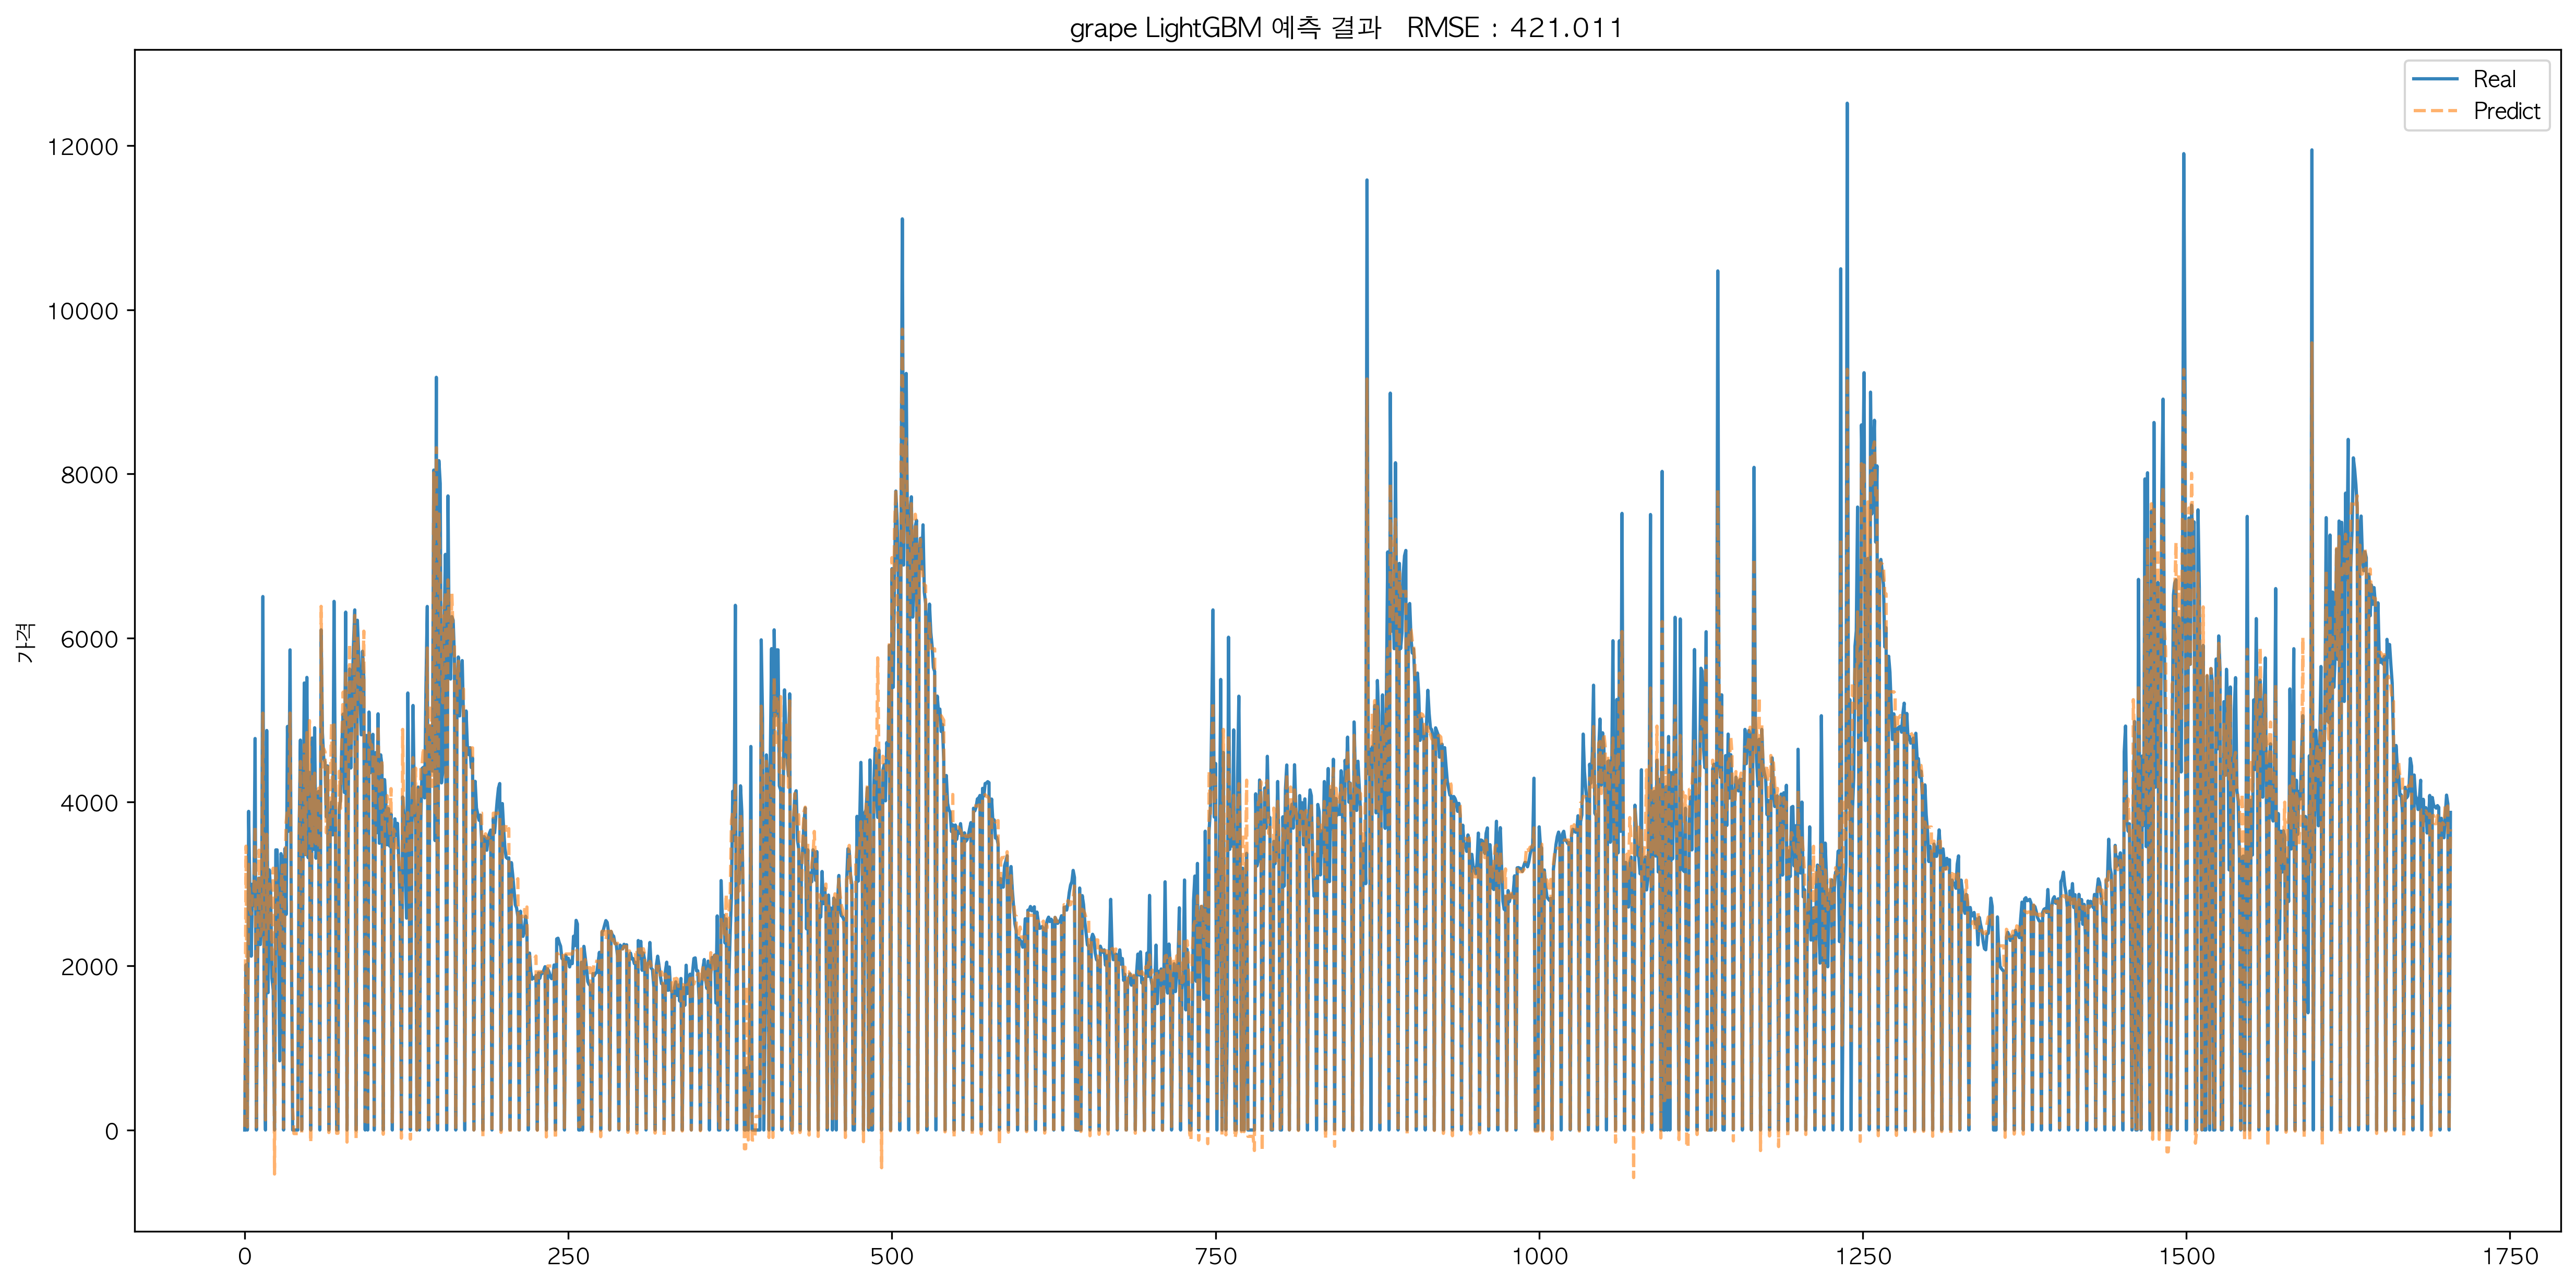

In [44]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('grape LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

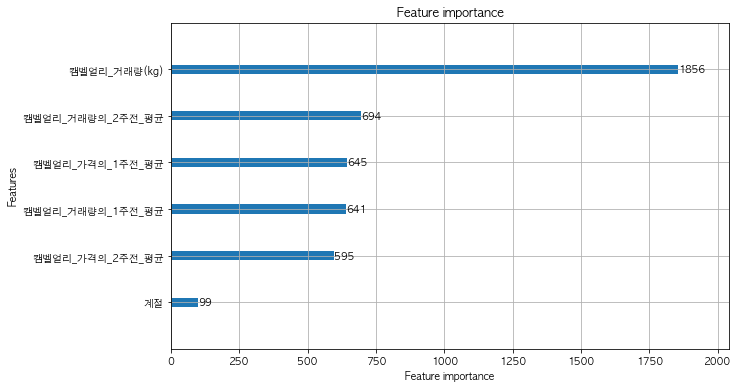

In [45]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [46]:
## 모델 예측

x_test = np.array([[370000, 270000, 10000, 3500000, 5000, 2]])

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 2791.068646824986 
confidence : 6958.2317056600605
ratio : 0.4


### 모델의 예측 결과
전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

[모델링참고](https://github.com/seongmoonKang/Data-Analysis-Capstone)

## 2. 샤인마스캇

In [18]:
shinemuscat.columns

Index(['date', '요일', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)', '샤인마스캇_거래량의_1주전_평균',
       '샤인마스캇_가격의_1주전_평균', '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균', '계절'],
      dtype='object')

In [18]:
shinemuscat['date'] = pd.to_datetime(shinemuscat['date'])
shinemuscat.set_index('date',drop=True,inplace=True)

In [19]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = '2020-08-31'
train_split_1 = '2020-09-01'
valid_split = '2020-09-28'
valid_split_1 = '2020-09-29'

feature = shinemuscat[['샤인마스캇_거래량(kg)', '샤인마스캇_거래량의_1주전_평균', '샤인마스캇_가격의_1주전_평균', 
              '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균', '계절']]
target = shinemuscat['샤인마스캇_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split_1:valid_split]
y_valid = target[train_split_1:valid_split]

X_test = feature[valid_split_1:]
y_test = target[valid_split_1:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 6) (1705,) (28, 6) (28,) (37, 6) (37,)


In [49]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [50]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 1705, number of used features: 6
[LightGBM] [Info] Start training from score 6930.746628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 889.667
Early stopping, best iteration is:
[59]	valid_0's l1: 865.548


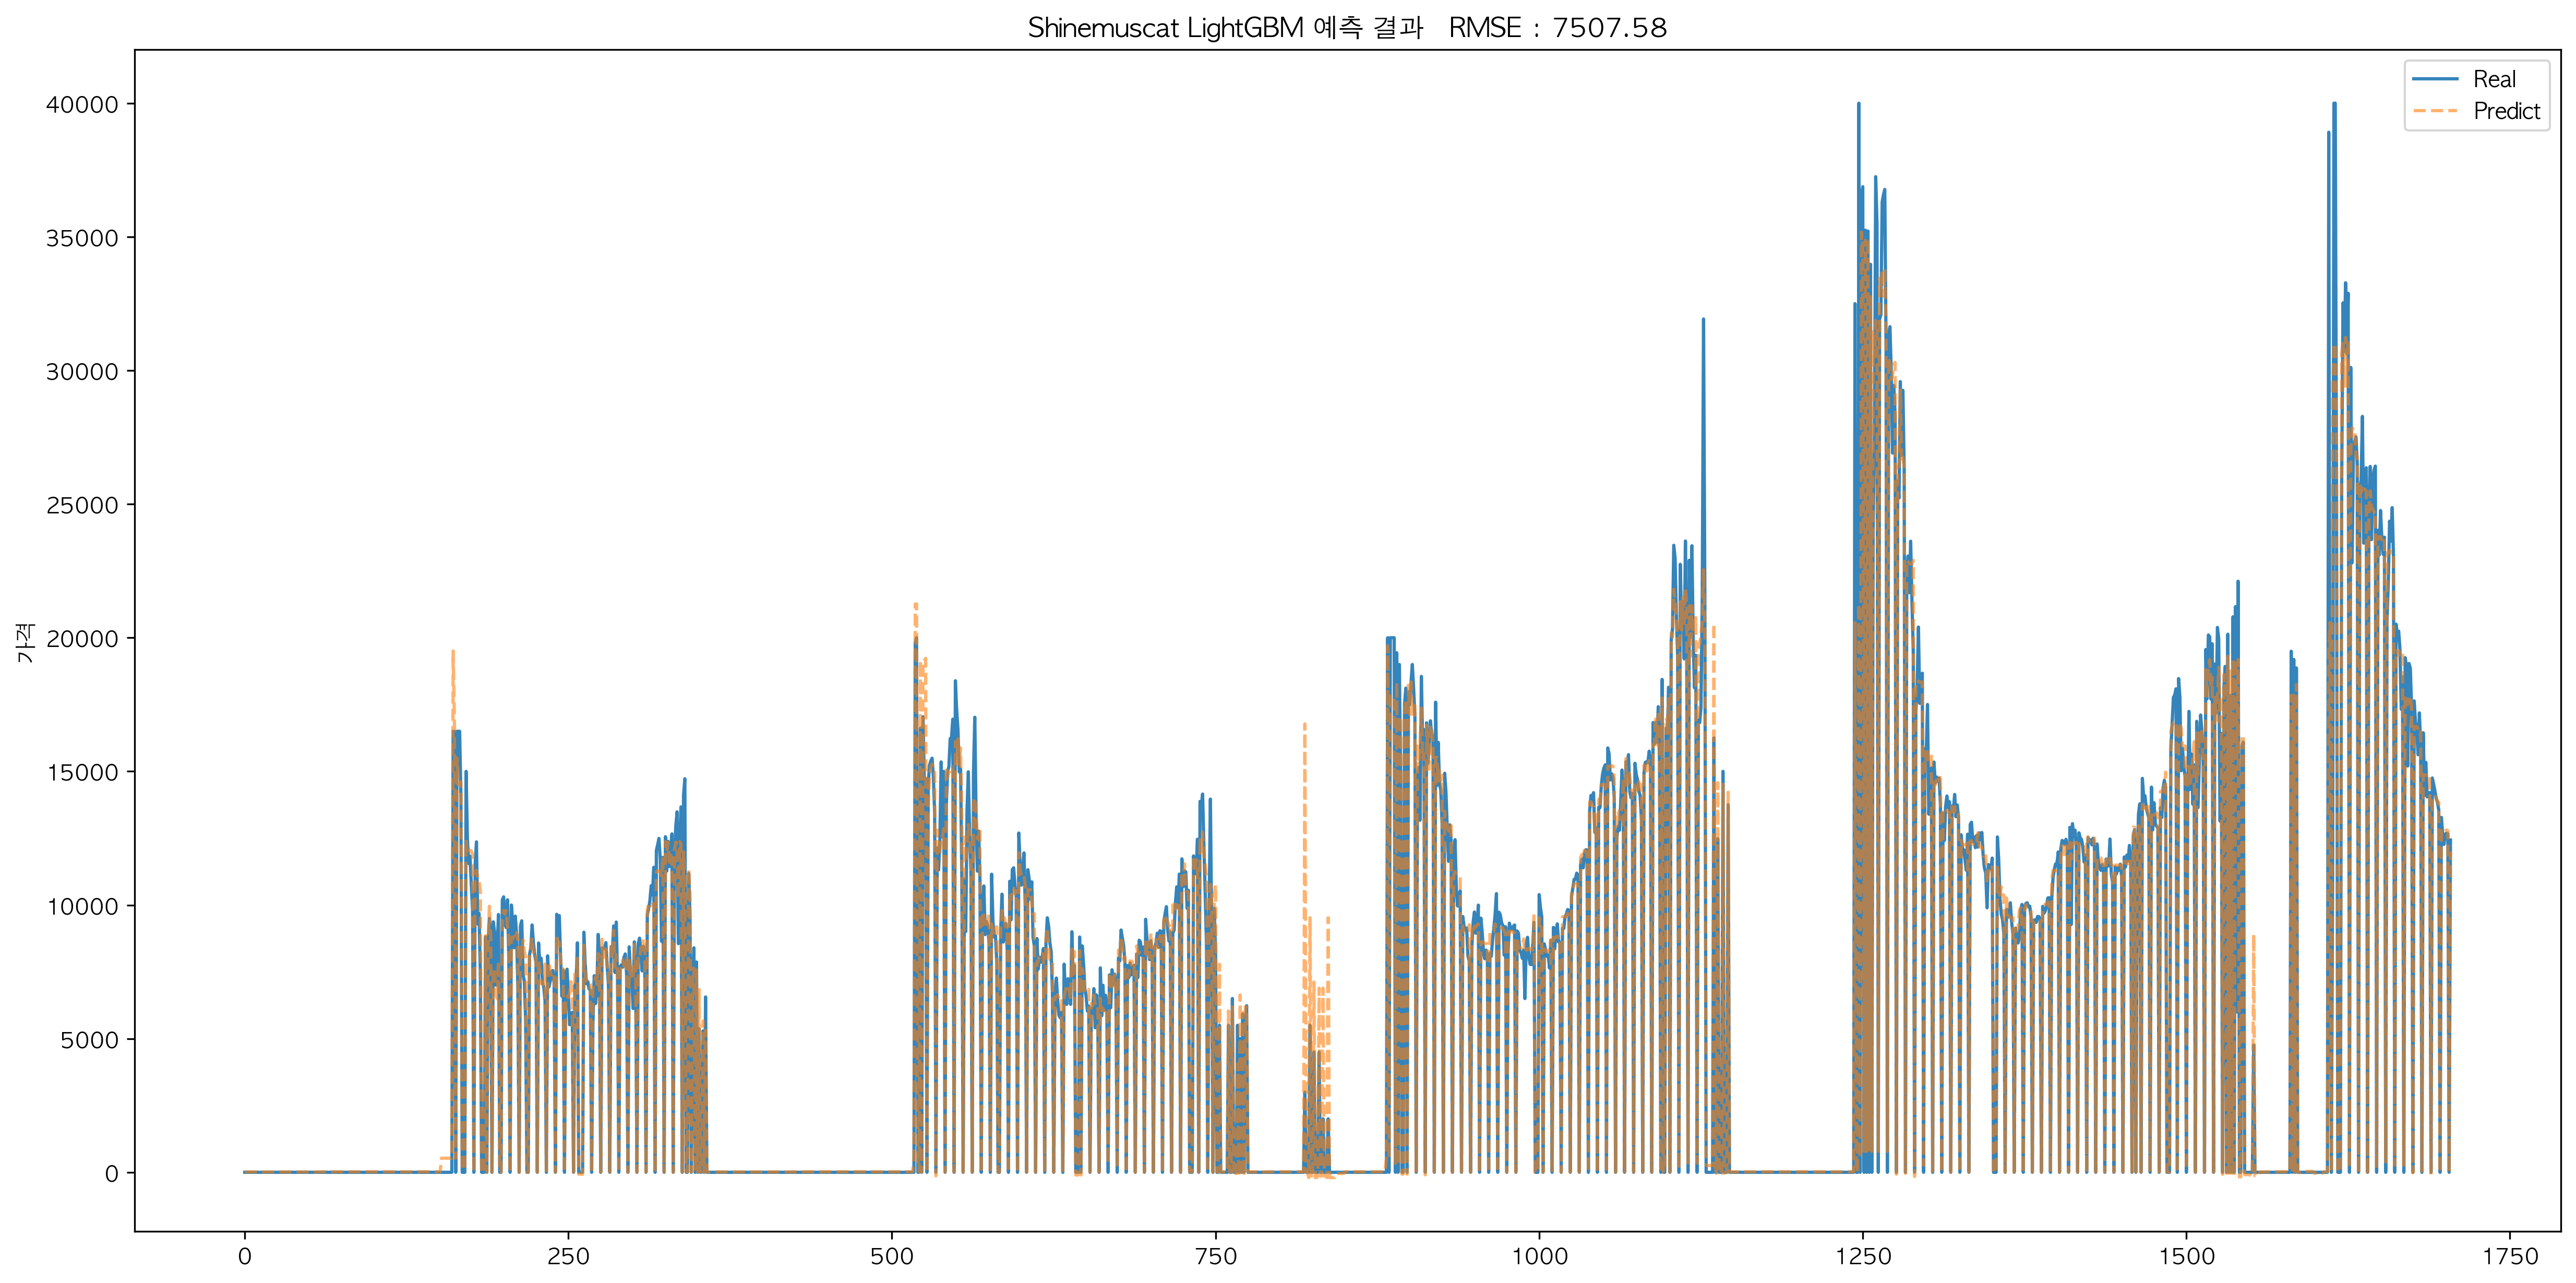

In [51]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

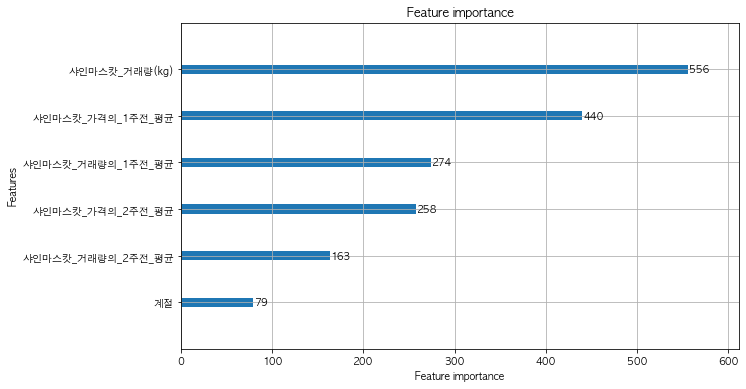

In [32]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [52]:
## 모델 예측

x_test = np.array([[7000, 27000, 10000, 35000, 25000, 3]])

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 18004.59396674357 
confidence : 10812.589475357392
ratio : 1.67


# LSTM
## 캠벨얼리


In [55]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL

train_split = 1705
valid_split = 1733

feature = ['캠벨얼리_거래량(kg)','캠벨얼리_거래량의_1주전_평균', '캠벨얼리_가격의_1주전_평균',
           '캠벨얼리_거래량의_2주전_평균', '캠벨얼리_가격의_2주전_평균', '계절']
target = grape[['캠벨얼리_가격(원/kg)']]

X_train = grape[feature][:train_split].values.reshape(-1,1,len(feature))
y_train = target[:train_split].values.reshape(-1,1,1)

X_valid = grape[feature][train_split:valid_split].values.reshape(-1,1,len(feature))
y_valid = target[train_split:valid_split].values.reshape(-1,1,1)

X_test = grape[feature][valid_split:].values.reshape(-1,1,len(feature))
y_test = target[valid_split:].values.reshape(-1,1,1)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 1, 6) (1705, 1, 1) (28, 1, 6) (28, 1, 1) (37, 1, 6) (37, 1, 1)


In [56]:
model = Sequential()
model.add(layers.Activation('relu'))
model.add(tf.compat.v1.keras.layers.LSTM(100, input_shape=(21,len(feature)), return_sequences=True))
model.add(Dropout(0.1))
model.add(layers.Dense(30))
model.add(Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=30)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/1000
48/48 [==============================] - 1s 4ms/step - loss: 13528674.0000 - val_loss: 22879116.0000
Epoch 2/1000
48/48 [==============================] - 0s 2ms/step - loss: 13449803.0000 - val_loss: 22715628.0000
Epoch 3/1000
48/48 [==============================] - 0s 2ms/step - loss: 13291181.0000 - val_loss: 22416444.0000
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 13030403.0000 - val_loss: 21979270.0000
Epoch 5/1000
48/48 [==============================] - 0s 2ms/step - loss: 12675856.0000 - val_loss: 21418236.0000
Epoch 6/1000
48/48 [==============================] - 0s 2ms/step - loss: 12241992.0000 - val_loss: 20763094.0000
Epoch 7/1000
48/48 [==============================] - 0s 2ms/step - loss: 11740933.0000 - val_loss: 20018048.0000
Epoch 8/1000
48/48 [==============================] - 0s 2ms/step - loss: 11202719.0000 - val_loss: 19220694.0000
Epoch 9/1000
48/48 [==============================] - 0s 2ms/step - loss: 10657117.0000 

48/48 [==============================] - 0s 2ms/step - loss: 2115231.2500 - val_loss: 3239302.7500
Epoch 146/1000
48/48 [==============================] - 0s 2ms/step - loss: 2118128.7500 - val_loss: 3257052.7500
Epoch 147/1000
48/48 [==============================] - 0s 2ms/step - loss: 2102539.5000 - val_loss: 3254686.7500
Epoch 148/1000
48/48 [==============================] - 0s 2ms/step - loss: 2073958.6250 - val_loss: 3237502.5000
Epoch 149/1000
48/48 [==============================] - 0s 2ms/step - loss: 2060405.1250 - val_loss: 3208167.2500
Epoch 150/1000
48/48 [==============================] - 0s 2ms/step - loss: 2077177.0000 - val_loss: 3226739.7500
Epoch 151/1000
48/48 [==============================] - 0s 2ms/step - loss: 2097824.5000 - val_loss: 3219205.2500
Epoch 152/1000
48/48 [==============================] - 0s 2ms/step - loss: 2060854.7500 - val_loss: 3203198.5000
Epoch 153/1000
48/48 [==============================] - 0s 2ms/step - loss: 2032444.2500 - val_loss: 31

Epoch 217/1000
48/48 [==============================] - 0s 2ms/step - loss: 1940720.8750 - val_loss: 2938955.0000
Epoch 218/1000
48/48 [==============================] - 0s 2ms/step - loss: 1925873.5000 - val_loss: 2916456.5000
Epoch 219/1000
48/48 [==============================] - 0s 2ms/step - loss: 1930225.0000 - val_loss: 2905798.5000
Epoch 220/1000
48/48 [==============================] - 0s 2ms/step - loss: 1956910.7500 - val_loss: 2912253.5000
Epoch 221/1000
48/48 [==============================] - 0s 2ms/step - loss: 1989914.8750 - val_loss: 2899520.2500
Epoch 222/1000
48/48 [==============================] - 0s 2ms/step - loss: 1949604.7500 - val_loss: 2922204.5000
Epoch 223/1000
48/48 [==============================] - 0s 2ms/step - loss: 1919780.2500 - val_loss: 2923590.7500


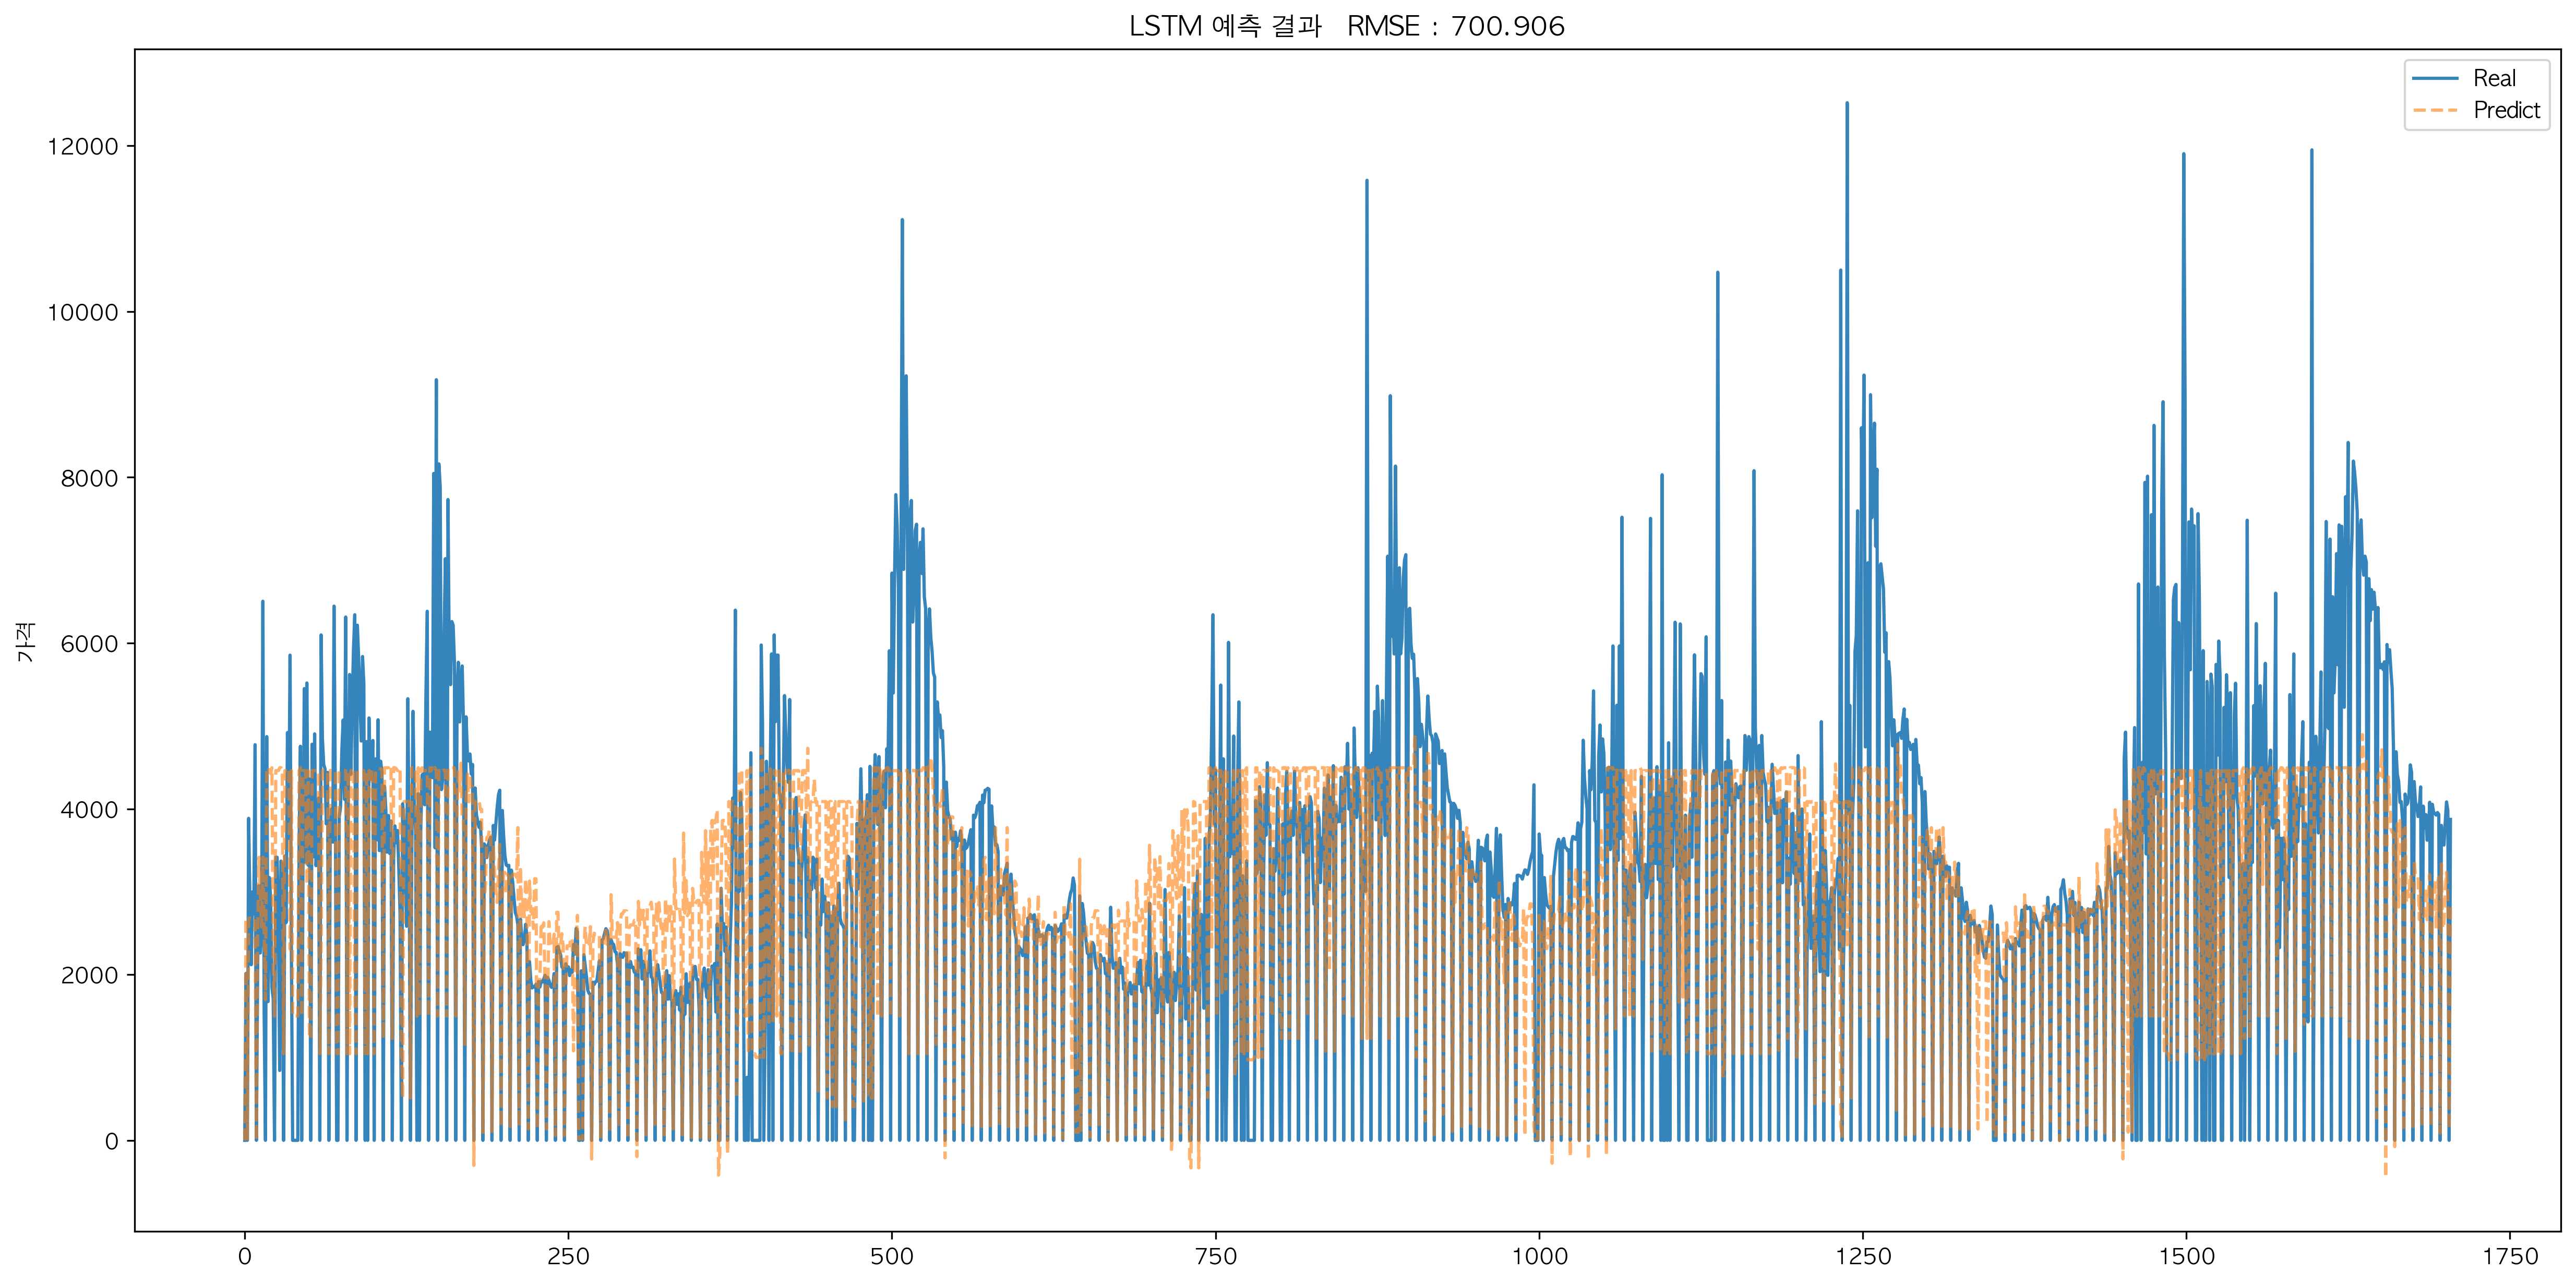

In [57]:
y_pred = model.predict(X_test)
RMSE = mean_squared_error(y_test.reshape(-1,1), y_pred.reshape(-1,1)) ** 0.5

plt.figure(figsize=(20, 10), dpi=300)
plt.title('LSTM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train.reshape(-1,1)), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()


## 샤인머스켓

In [63]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL

train_split = 1705
valid_split = 1733

feature = ['샤인마스캇_거래량(kg)', '샤인마스캇_거래량의_1주전_평균', '샤인마스캇_가격의_1주전_평균', 
              '샤인마스캇_거래량의_2주전_평균', '샤인마스캇_가격의_2주전_평균', '계절']
target = shinemuscat[['샤인마스캇_가격(원/kg)']]

X_train = shinemuscat[feature][:train_split].values.reshape(-1,1,len(feature))
y_train = target[:train_split].values.reshape(-1,1,1)

X_valid = shinemuscat[feature][train_split:valid_split].values.reshape(-1,1,len(feature))
y_valid = target[train_split:valid_split].values.reshape(-1,1,1)

X_test = shinemuscat[feature][valid_split:].values.reshape(-1,1,len(feature))
y_test = target[valid_split:].values.reshape(-1,1,1)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 1, 6) (1705, 1, 1) (28, 1, 6) (28, 1, 1) (37, 1, 6) (37, 1, 1)


In [61]:
model = Sequential()
model.add(layers.Activation('relu'))
model.add(tf.compat.v1.keras.layers.LSTM(100, input_shape=(21,len(feature)), return_sequences=True))
model.add(Dropout(0.1))
model.add(layers.Dense(30))
model.add(Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=30)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/1000
48/48 [==============================] - 1s 4ms/step - loss: 95561912.0000 - val_loss: 253031856.0000
Epoch 2/1000
48/48 [==============================] - 0s 2ms/step - loss: 95439544.0000 - val_loss: 252723216.0000
Epoch 3/1000
48/48 [==============================] - 0s 2ms/step - loss: 95181456.0000 - val_loss: 252139392.0000
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 94740952.0000 - val_loss: 251210704.0000
Epoch 5/1000
48/48 [==============================] - 0s 2ms/step - loss: 93969504.0000 - val_loss: 249509856.0000
Epoch 6/1000
48/48 [==============================] - 0s 2ms/step - loss: 92823400.0000 - val_loss: 247391024.0000
Epoch 7/1000
48/48 [==============================] - 0s 2ms/step - loss: 91390144.0000 - val_loss: 244499920.0000
Epoch 8/1000
48/48 [==============================] - 0s 2ms/step - loss: 89502392.0000 - val_loss: 240937760.0000
Epoch 9/1000
48/48 [==============================] - 0s 2ms/step - loss: 872374

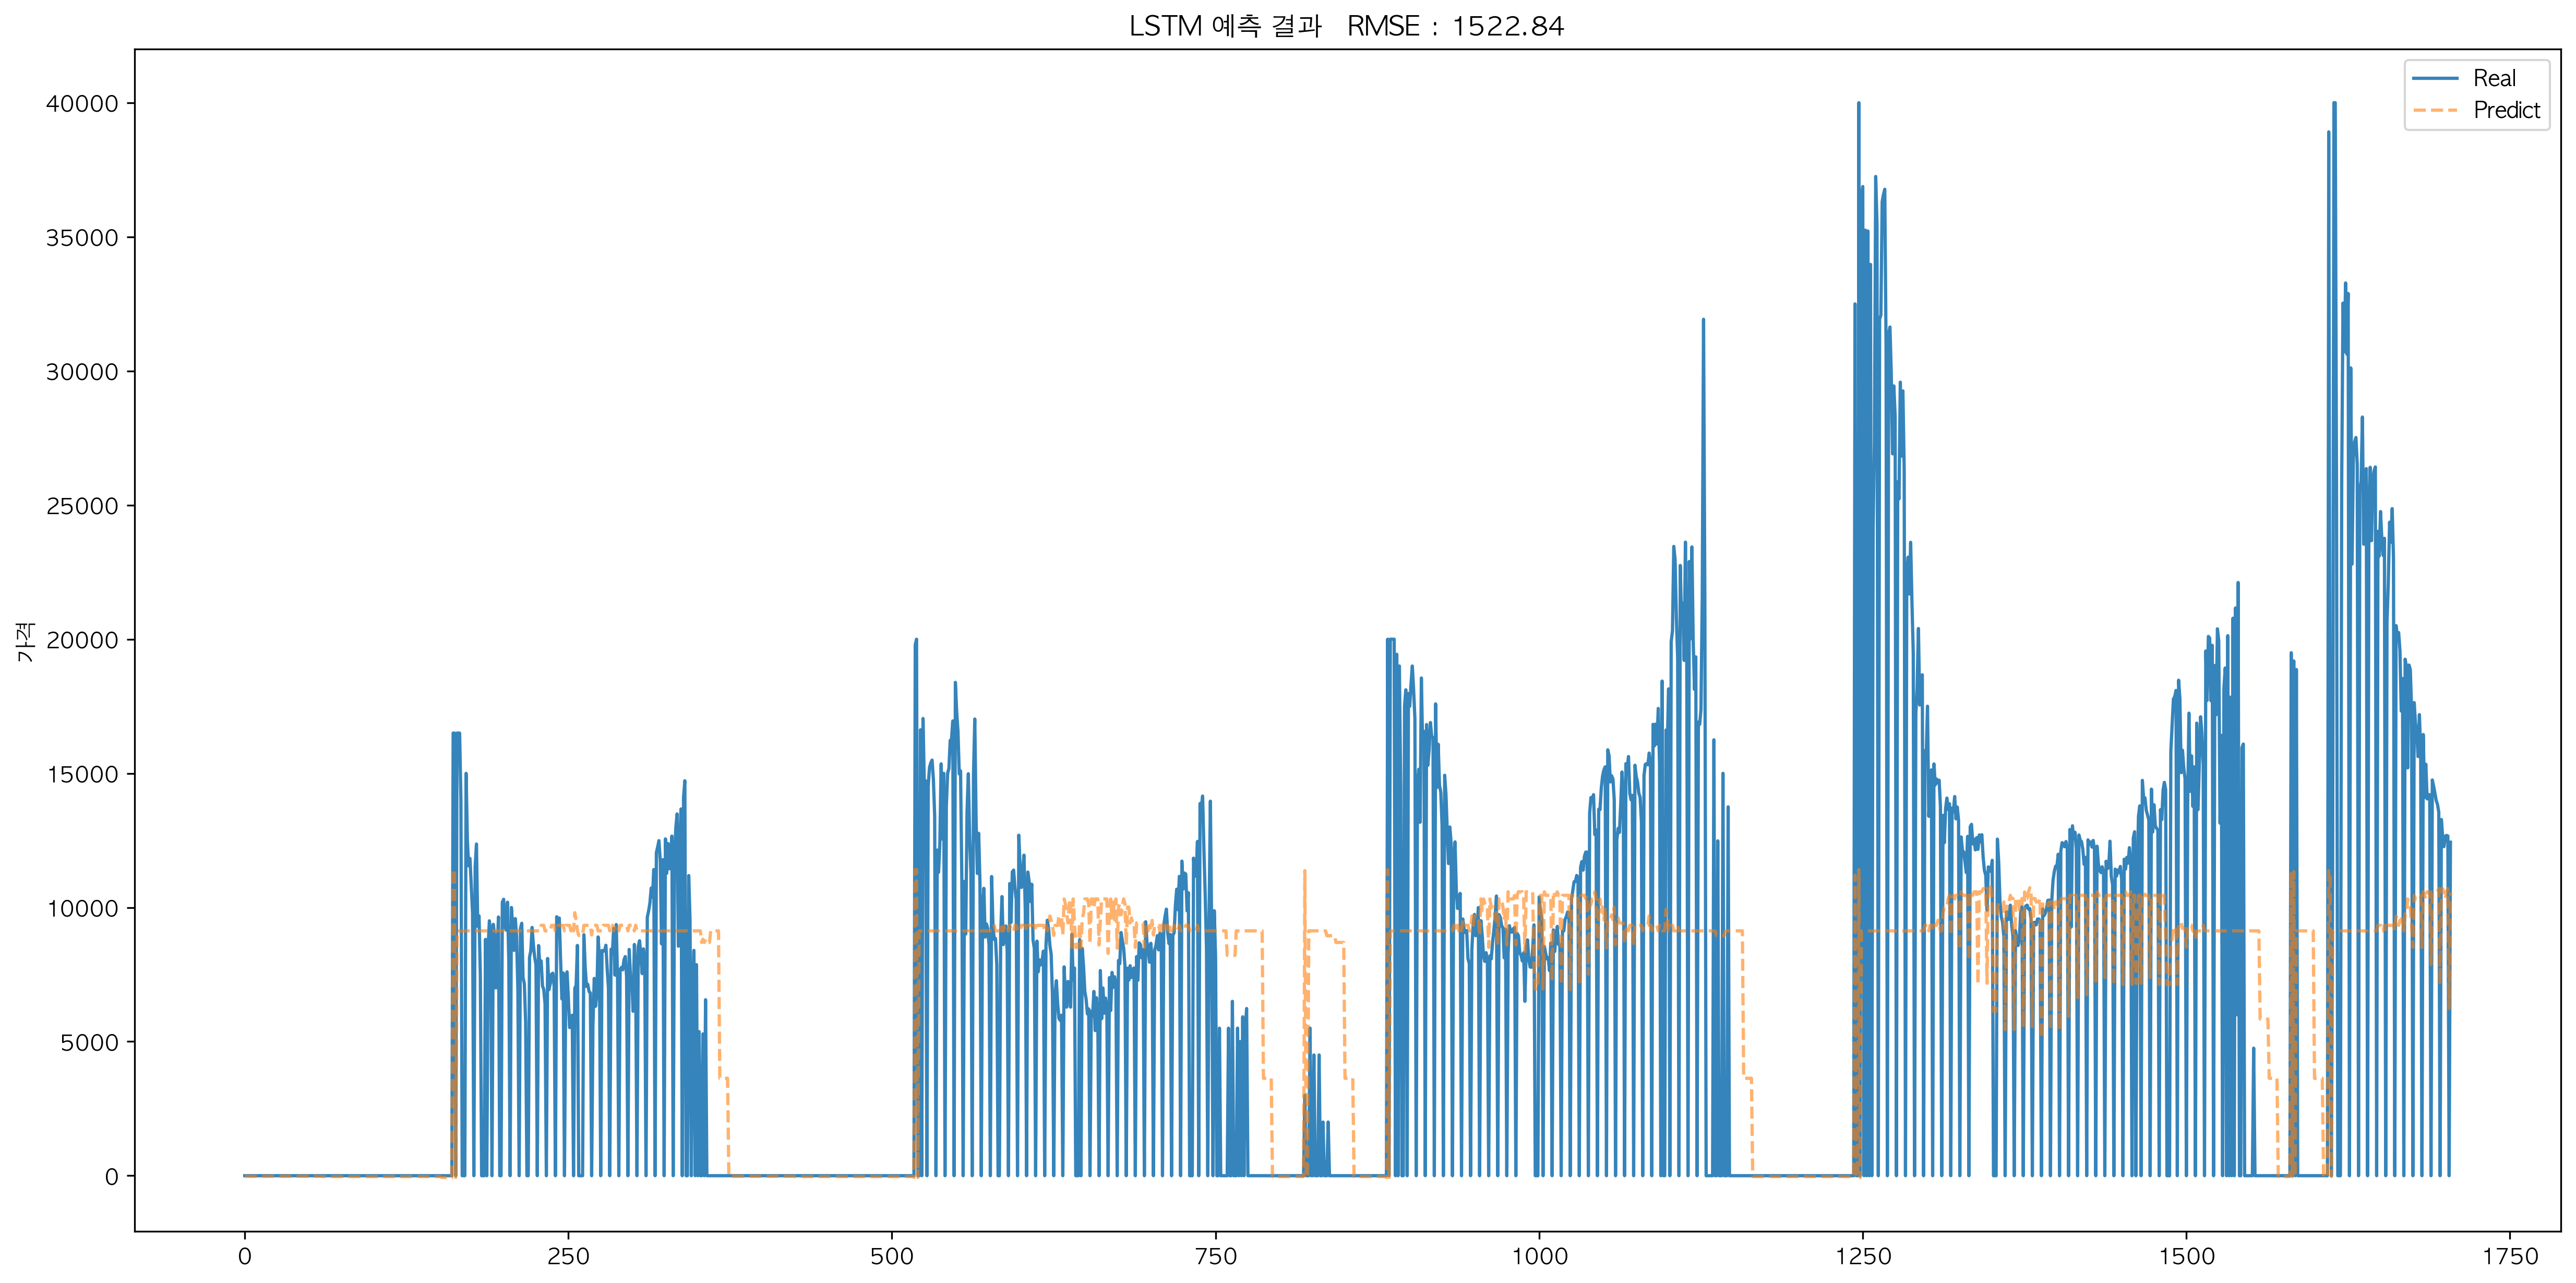

In [62]:
y_pred = model.predict(X_test)
RMSE = mean_squared_error(y_test.reshape(-1,1), y_pred.reshape(-1,1)) ** 0.5

plt.figure(figsize=(20, 10), dpi=300)
plt.title('LSTM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train.reshape(-1,1)), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()